In [144]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [303]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_figlet.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_figlettest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.324094,0.006131,911.319040,49312.485831,0.010610,1355.186590,7327.460939,1.0,103.0,0.101562,6.0,65.278711,2.508814e+10,19.192693
1,0.435870,0.012711,12652.088889,99214.222222,0.010610,5997.000000,17316.288889,1.0,251.0,0.103955,6.0,65.278711,2.508814e+10,19.192693
2,0.468027,0.012978,12652.088889,101398.755556,0.033712,8108.177778,21682.377778,1.0,396.0,0.106485,6.0,11.526728,2.508814e+10,19.333974
3,0.465293,0.014400,11832.888889,128341.333333,0.033712,9869.933333,22551.844444,1.0,542.0,0.105202,6.0,11.526728,2.508814e+10,19.333974
4,0.461566,0.010489,0.000000,90294.044444,0.037694,7584.933333,18696.533333,1.0,585.0,0.102712,6.0,11.493428,2.508814e+10,19.054890


In [304]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [305]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [306]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
df_t['networkTransmitted'] = df['networkTransmitted']
df_t['networkReceived'] = df['networkReceived']
df_t['diskio'] = df['diskio']
df_t['diskioRead'] = df['diskioRead']
df_t['diskioWritten'] = df['diskioWritten']


df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['diskio'] = df_test['diskio']
df_ttest['networkTransmitted'] = df_test['networkTransmitted']
df_ttest['networkReceived'] = df_test['networkReceived']

df_ttest['diskio'] = df_test['diskio']
df_ttest['diskioRead'] = df_test['diskioRead']
df_ttest['diskioWritten'] = df_test['diskioWritten']


#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted,networkReceived,diskio,diskioRead,diskioWritten
0,2.624204,481.508966,0.101562,103.0,7327.460939,1355.186590,0.006131,911.319040,49312.485831
1,2.624204,481.508966,0.103955,251.0,17316.288889,5997.000000,0.012711,12652.088889,99214.222222
2,0.463374,485.053440,0.106485,396.0,21682.377778,8108.177778,0.012978,12652.088889,101398.755556
3,0.463374,485.053440,0.105202,542.0,22551.844444,9869.933333,0.014400,11832.888889,128341.333333
4,0.462036,478.051738,0.102712,585.0,18696.533333,7584.933333,0.010489,0.000000,90294.044444


In [307]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted,networkReceived,diskio,diskioRead,diskioWritten
3290,2.379505,572.538470,0.235285,18802.0,17683.788229,16863.131223,0.0,0.0,16386.913229
3291,2.332224,572.538470,0.235285,26274.0,13206.277229,9772.450431,0.0,0.0,10652.440651
3292,2.332224,572.065382,0.235285,33763.0,8820.597194,6643.506681,0.0,0.0,7558.707784
3293,2.324085,572.065382,0.326864,38767.0,8188.234771,4092.783963,0.0,0.0,7919.461297
3294,2.324085,572.486246,0.235285,33641.0,7087.822222,4711.066667,0.0,0.0,6280.533333


In [308]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [309]:
df_t.shape

(2579, 9)

In [310]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

In [311]:
feature_set = ['total_cpu_util', 'total_mem_util', 'responsetime', 'requests', 'networkTransmitted', 'networkReceived', 'diskio', 'diskioRead', 'diskioWritten' ]

train_feature_set = ['total_cpu_util', 'total_mem_util', 'responsetime', 'networkTransmitted', 'networkReceived', 'diskio', 'diskioRead', 'diskioWritten']

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


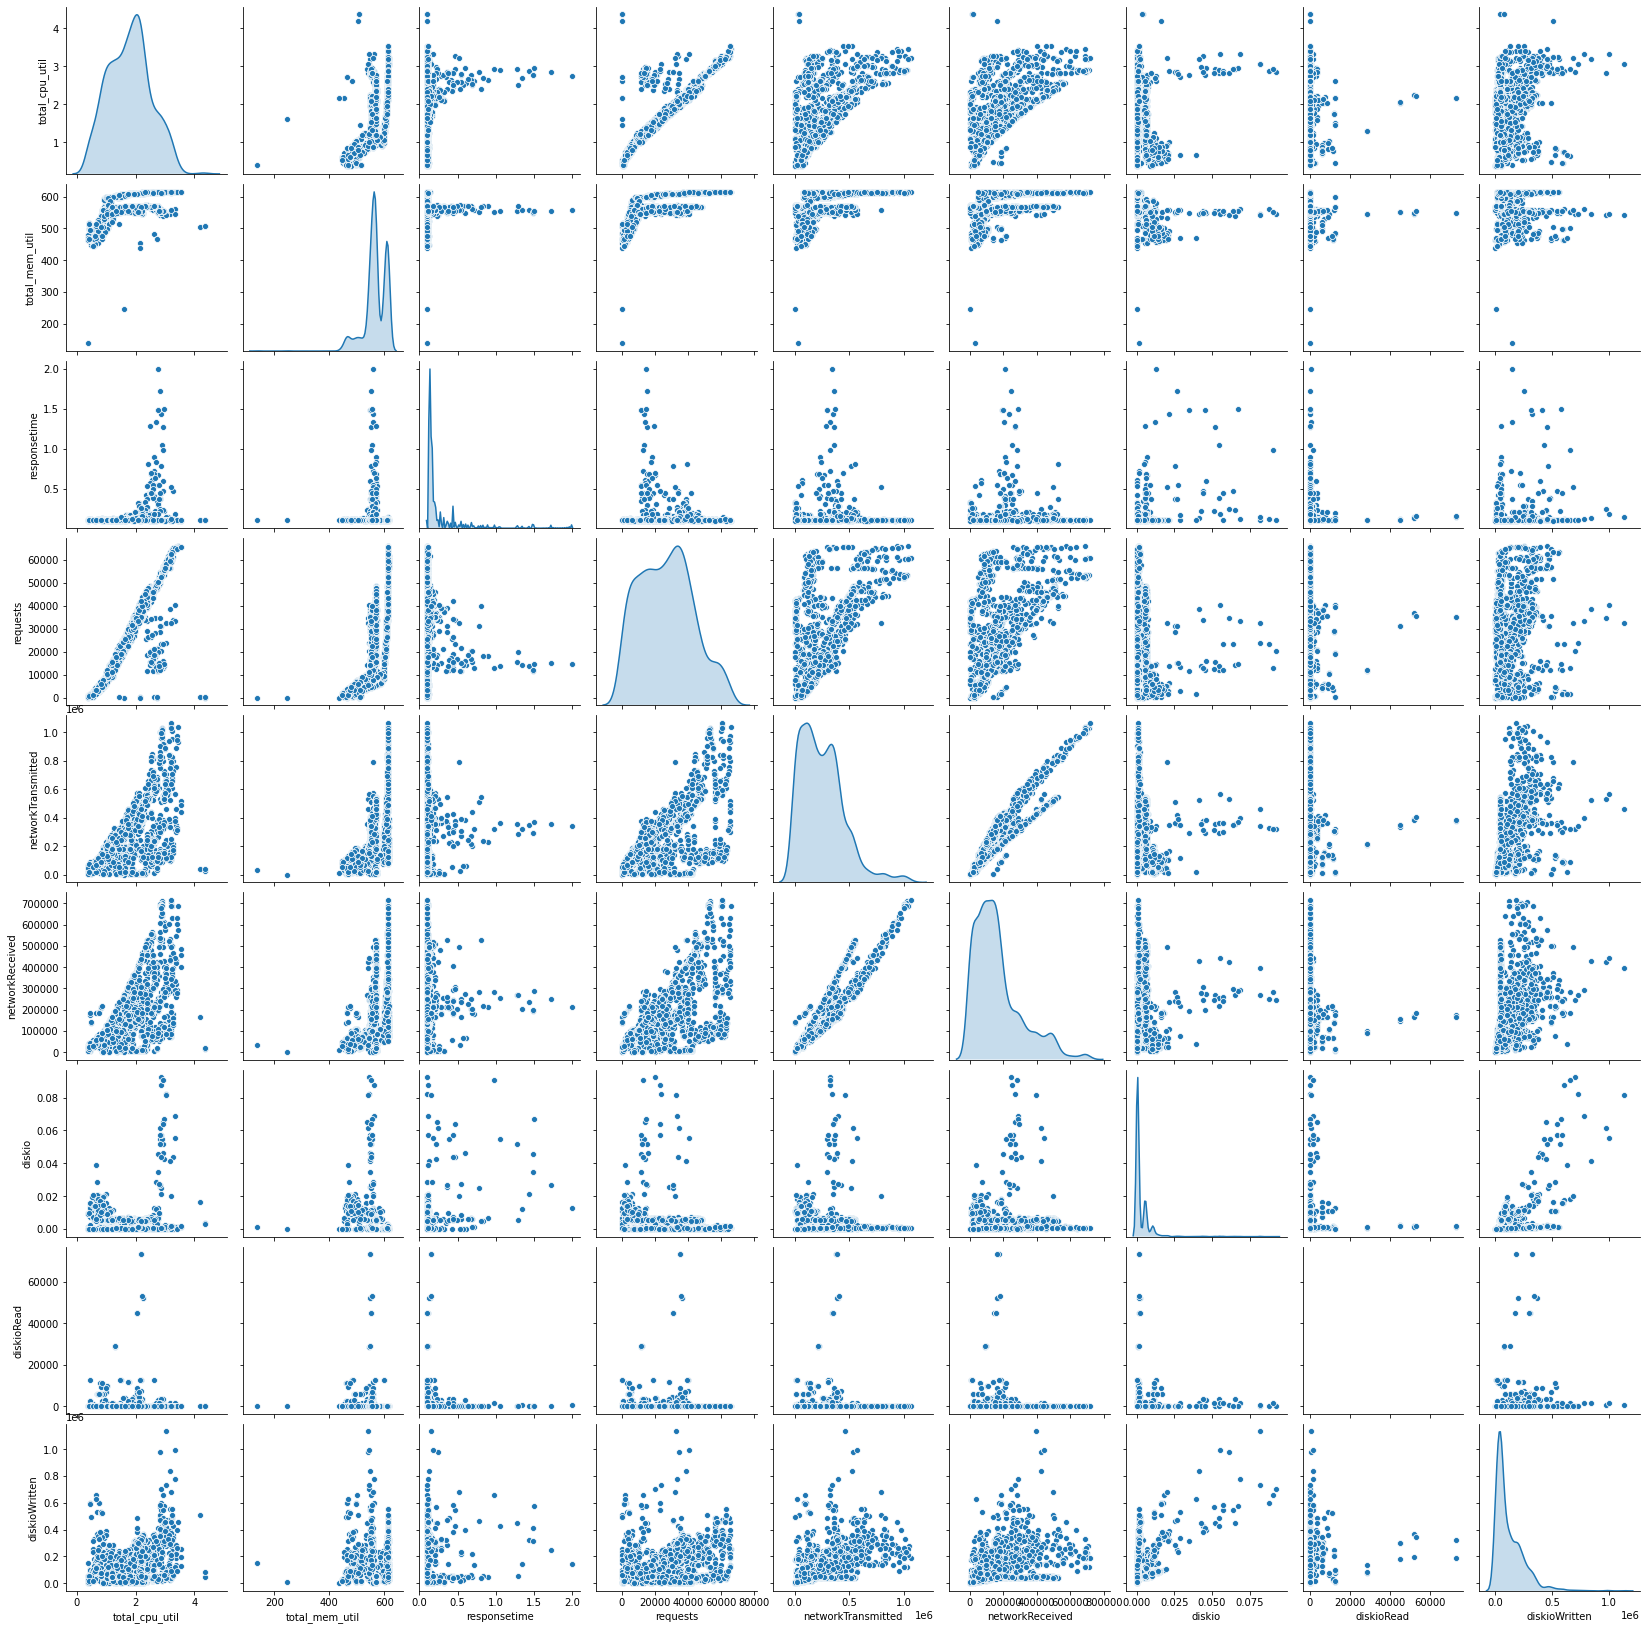

In [312]:
sns.pairplot(train_dataset[feature_set], diag_kind='kde')

In [313]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,2063.0,1.802449,0.715306,0.369352,1.240840,1.819273,2.244835,4.363428e+00
total_mem_util,2063.0,567.570779,39.498693,137.219482,552.863232,568.009114,604.695245,6.164957e+02
responsetime,2063.0,0.129342,0.115991,0.099105,0.103883,0.107086,0.113091,1.999501e+00
requests,2063.0,27122.444014,16215.375596,31.000000,13849.500000,26898.000000,38447.000000,6.610800e+04
networkTransmitted,2063.0,254690.080013,198912.046987,1399.743320,101155.777778,225753.333333,367404.578645,1.066298e+06
networkReceived,2063.0,168417.493322,141962.448391,1315.577778,66970.458872,136841.085357,220784.956031,7.158344e+05
diskio,2063.0,0.003199,0.007562,0.000000,0.000178,0.000533,0.005067,9.241364e-02
diskioRead,2063.0,532.243334,3864.696768,0.000000,0.000000,0.000000,0.000000,7.318349e+04
diskioWritten,2063.0,123177.807982,122390.436943,0.000000,42416.355556,75912.533333,187369.244444,1.133694e+06


In [314]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [315]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted,networkReceived,diskio,diskioRead,diskioWritten
259,1.923371,568.192205,0.103361,34174.0,380643.533333,352837.800000,0.005511,0.000000,50790.400000
1301,2.717520,612.240998,0.114410,48274.0,683935.401436,422238.505811,0.000800,0.000000,144267.016289
3131,1.957293,570.568704,0.103025,32914.0,9113.133333,5037.022222,0.000089,0.000000,5825.422222
3063,1.669178,570.091930,0.105804,26452.0,25404.266667,22560.088889,0.000000,0.000000,10285.511111
518,0.877700,480.162816,0.106193,5186.0,159226.266667,90046.511111,0.009600,182.044444,193877.333333


In [316]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [317]:
input = np.array(train_features[train_feature_set])

input_normalizer = preprocessing.Normalization(input_shape=[len(train_feature_set),])
input_normalizer.adapt(input)

In [318]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 28000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

In [291]:
def plot_training(train_labels, train_predictions):
    #a = plt.axes(aspect='equal')
    plt.scatter(range(0,len(train_labels)),train_labels, label="actual")
    plt.scatter(range(0,len(train_predictions)), train_predictions,  label="predicted")
    plt.legend()
    plt.xlabel('Unit Time')
    plt.ylabel('train requests')
    #lims = [0, 1]
    #plt.xlim(lims)
    #plt.ylim(lims)
    #_ = plt.plot()
    return plt.show()
def plot_prediction(test_labels, test_predictions):
    #a = plt.axes(aspect='equal')
    plt.scatter(range(0,len(test_labels)),test_labels, label="actual")
    plt.scatter(range(0,len(test_labels)), test_predictions,  label="predicted")
    plt.legend()
    plt.xlabel('Unit Time')
    plt.ylabel('requests')
    #lims = [0, 1]
    #plt.xlim(lims)
    #plt.ylim(lims)
    #_ = plt.plot()
    return plt.show()

In [321]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
from keras import regularizers

def build_and_compile_autoencodermodel(input_shape):
    input_img = keras.Input(shape=(input_shape,))
    #encoded = layers.Dense(512, activation='relu')(input_img)
    #encoded = layers.Dense(256, activation='relu')(encoded)
    #encoded = layers.Dense(128, activation='relu')(encoded)
    #encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(input_img)
    encoded = layers.Dense(5, activation='relu')(encoded)
    
    decoded = layers.Dense(32, activation='relu')(encoded)
    #decoded = layers.Dense(64, activation='relu')(decoded)
    #decoded = layers.Dense(128, activation='relu')(decoded)
    #decoded = layers.Dense(256, activation='relu')(decoded)
    #decoded = layers.Dense(512, activation='relu')(decoded)
    decoded = layers.Dense(input_shape, activation='sigmoid')(decoded)
    
    #model.compile(loss='mean_absolute_error',
    #            optimizer=tf.keras.optimizers.Adam(0.001))
    
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile("adam", loss='mae')

    return autoencoder


def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(64, activation='relu',name="dense_three"),
      layers.Dense(1,name="dense_four")
  ])
  #model.add(layers.Embedding(input_dim=64, output_dim=64))  
  #model.add(layers.LSTM(128))
  #model.add(layers.Dense(1))  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Model: "functional_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_412 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_413 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_414 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_415 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


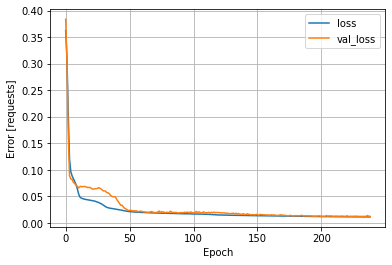

Model: "sequential_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_244 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


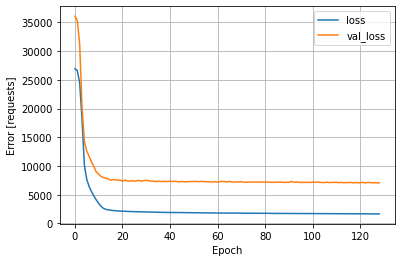

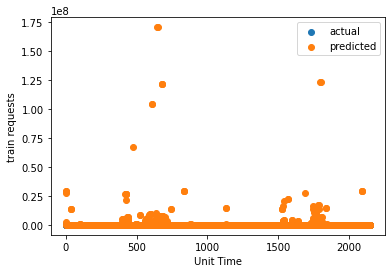

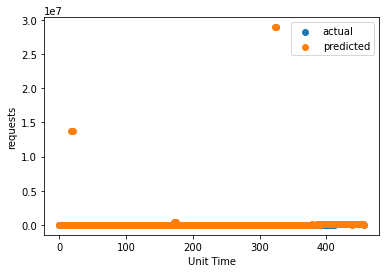

Model: "functional_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_416 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_417 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_418 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_419 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


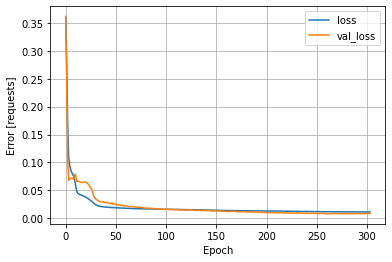

Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_245 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


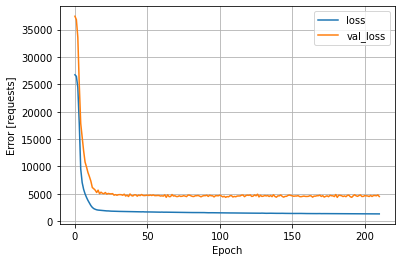

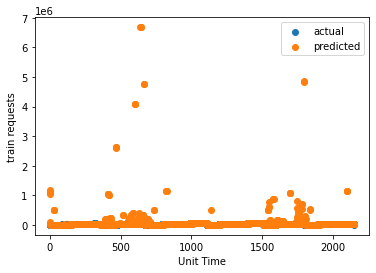

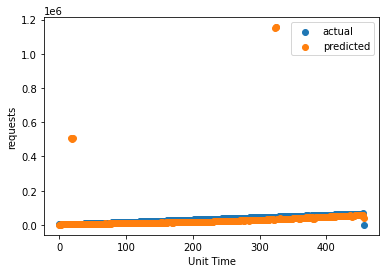

Model: "functional_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_420 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_421 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_422 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_423 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


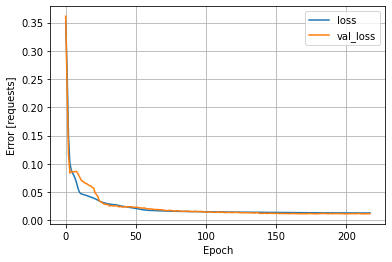

Model: "sequential_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_246 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


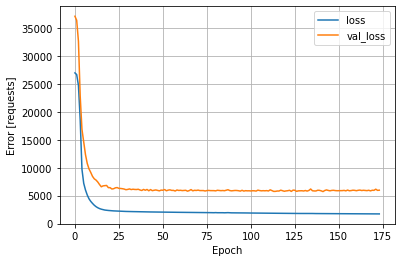

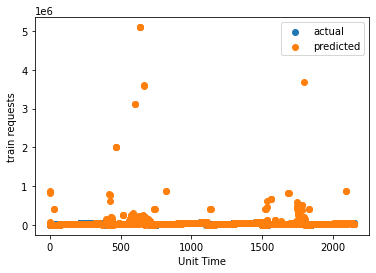

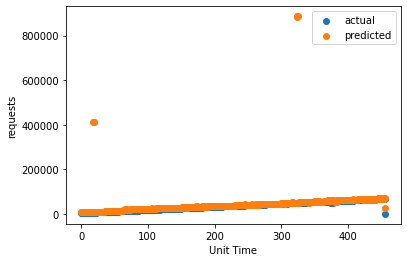

Model: "functional_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_424 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_425 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_426 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_427 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


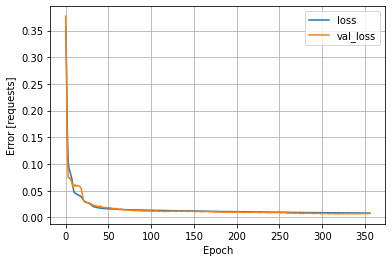

Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_247 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


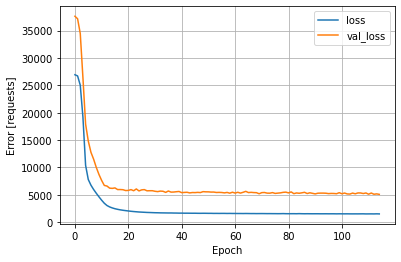

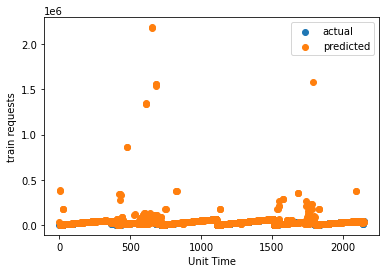

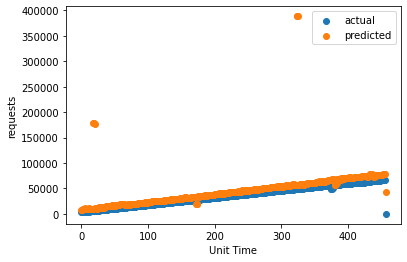

Model: "functional_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_428 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_429 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_430 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_431 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


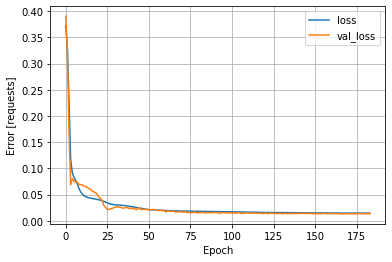

Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_248 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


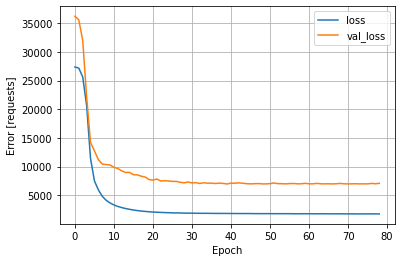

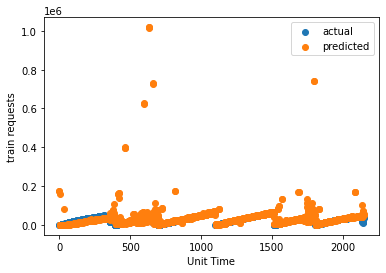

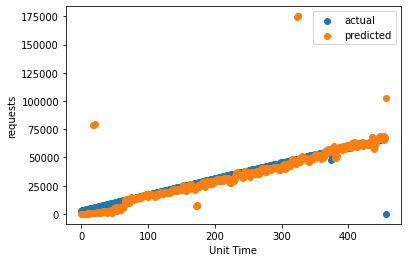

Model: "functional_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_432 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_433 (Dense)            (None, 5)                 165       
_________________________________________________________________
dense_434 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_435 (Dense)            (None, 8)                 264       
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________
None


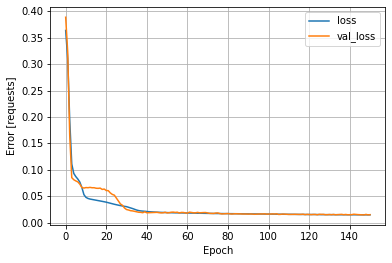

Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_249 (Normaliza (None, 8)                 17        
_________________________________________________________________
dense_one (Dense)            (None, 64)                576       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 64)                4160      
_________________________________________________________________
dense_four (Dense)           (None, 1)                 65        
Total params: 8,978
Trainable params: 8,961
Non-trainable params: 17
_________________________________________________________________
None


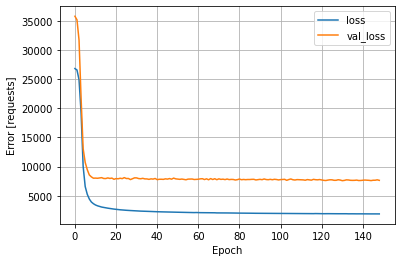

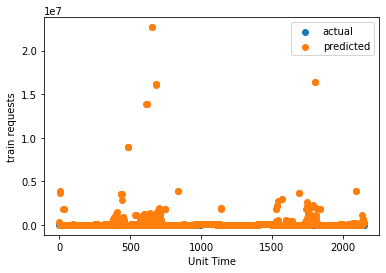

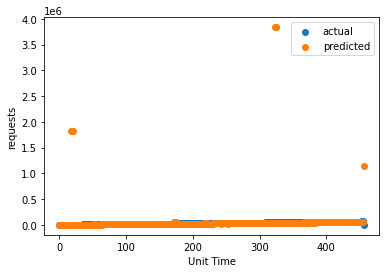

In [322]:
#%%time
import sklearn
i = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,train_feature_set].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    std_scale = sklearn.preprocessing.MinMaxScaler().fit(X)
    
    X_train_std = std_scale.transform(X[train_index])
    X_test_std  = std_scale.transform(X[test_index])
    
    #std_scale = sklearn.preprocessing.StandardScaler().fit(y)
    
    #y_train_std = std_scale.transform(y[train_index])
    #y_test_std  = std_scale.transform(y[test_index])

    #train_features, val_features = X_train_std, X_test_std
    #train_labels, val_labels = y_train_std, y_test_std
    
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    

# Create Model
    dnn_model = None
    dnn_model = build_and_compile_autoencodermodel(len(train_feature_set))

    print(dnn_model.summary())

    history = dnn_model.fit(
        X_train_std, X_train_std,
        validation_split=0.02, batch_size=64,
        shuffle=True,
        verbose=0, epochs=6000, callbacks=[callback])
    #print(history)
    
    #print(r2_score(test_labels, test_predictions)*100)
    plot_loss(history)
    new_data = dnn_model.predict(X_train_std)
    new_data = std_scale.inverse_transform(new_data)
    
    
    input = new_data
    input_normalizer = preprocessing.Normalization(input_shape=[len(train_feature_set),])
    input_normalizer.adapt(input)
    
    dnn_model = None
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        new_data, train_labels,
        validation_split=0.02, 
        verbose=0, epochs=6000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss.append(dnn_model.evaluate(val_features, val_labels,verbose=0))
    
    ## Make Predictions
    train_predictions = dnn_model.predict(train_features).flatten()

    plot_training(train_labels, train_predictions)
    
    test_predictions = dnn_model.predict(test_features).flatten()
    plot_prediction(test_labels, test_predictions)
    
    R = r2_score(test_labels, test_predictions)*100
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

In [320]:
data = np.array([model, loss/max(test_labels), score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,0.1134002533106874,28.81151391979668
1,dnn_model_1,0.053343912942434575,96.5723316854717
2,dnn_model_2,0.10307346708883174,87.28207637064016
3,dnn_model_3,0.05720423982330575,95.99182876548713
4,dnn_model_4,0.08422467504706255,85.39485201904957
5,dnn_model_5,0.04390911277771565,96.81355795367737


In [323]:
data = np.array([model, loss/max(test_labels), score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,24.70592335793633,-1974618.149814381
1,dnn_model_1,0.4972218533325878,-2776.6698650737626
2,dnn_model_2,0.672089402538582,-1574.9043488773862
3,dnn_model_3,0.262906176610378,-200.43351735116423
4,dnn_model_4,0.16831024472526654,48.20591862939425
5,dnn_model_5,2.496353118243495,-34708.92088527646


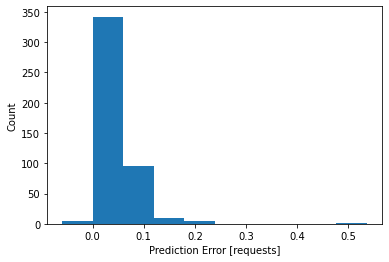

In [215]:
error = (test_predictions - test_labels)/max(test_labels)
plt.hist(error)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')